# How to create an ensemble plot

The data of the Climate Change Database is stored in gzipped csv tables on github. These can be loaded into a pandas frame without any further effort by simply adressing it:

In [294]:
import pandas as pd

url = 'https://raw.githubusercontent.com/climate-change-database/cc-data/master/CMIP6/cmip6-aggregated-global-tas-r1i1p1f1-amon.csv.gz'

catalog = pd.read_csv(url, parse_dates=['time'])

This table contains preprocessed global mean datasets of variable `tas` on a monthly temporal resolution from ESGF CMIP6 data. Let's have a look:

In [295]:
catalog

,experiment_id,source_id,time,tas
0,historical,ACCESS-CM2,1900-01-01,285.105561
1,historical,ACCESS-CM2,1900-02-01,285.457167
2,historical,ACCESS-CM2,1900-03-01,286.029045
3,historical,ACCESS-CM2,1900-04-01,287.114317
4,historical,ACCESS-CM2,1900-05-01,287.935325
...,...,...,...,...
250843,ssp585,NorESM2-MM,2100-08-01,293.172965
250844,ssp585,NorESM2-MM,2100-09-01,292.570618
250845,ssp585,NorESM2-MM,2100-10-01,291.475254
250846,ssp585,NorESM2-MM,2100-11-01,290.480686


In [296]:
catalog.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250848 entries, 0 to 250847
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   experiment_id  250848 non-null  object        
 1   source_id      250848 non-null  object        
 2   time           250848 non-null  datetime64[ns]
 3   tas            116364 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 7.7+ MB


In [297]:
catalog.describe()

,tas
count,116364.000000
mean,288.605588
std,1.928302
min,283.290924
25%,287.186413
50%,288.586765
75%,289.922251
max,296.723521


Ok, already lots of information here. Now, assume we want to get ensemble data of annual means for all available scenarios. So which scenarios are in the table?

In [298]:
catalog.experiment_id.unique()

array(['historical', 'ssp126', 'ssp245', 'ssp585'], dtype=object)

Alright! And what models are available?

In [299]:
catalog.source_id.unique()

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CanESM5',
       'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0',
       'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'KACE-1-0-G', 'KIOST-ESM', 'MIROC6', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM'],
      dtype=object)

Ok, now let's create annual mean data for each source_id and each experiment_id! But how? We will group the whole table by the source_id and the experiment id! Let's have an example here:

In [300]:
catalog.groupby(by=['source_id', 'experiment_id']).get_group(('MPI-ESM1-2-HR','historical'))

,experiment_id,source_id,time,tas
48240,historical,MPI-ESM1-2-HR,1900-01-01,285.136114
48241,historical,MPI-ESM1-2-HR,1900-02-01,285.480648
48242,historical,MPI-ESM1-2-HR,1900-03-01,286.061991
48243,historical,MPI-ESM1-2-HR,1900-04-01,286.955928
48244,historical,MPI-ESM1-2-HR,1900-05-01,288.077154
...,...,...,...,...
50647,historical,MPI-ESM1-2-HR,2100-08-01,NaN
50648,historical,MPI-ESM1-2-HR,2100-09-01,NaN
50649,historical,MPI-ESM1-2-HR,2100-10-01,NaN
50650,historical,MPI-ESM1-2-HR,2100-11-01,NaN


Ok, that looks good. Now lets simply go throug all groups and compute annual means of tas. We store the annual means in a new table and add the source_id and experiment_id as additional columns to remember where the data came from. We will produce a list of tables for all source_ids and experiment_ids containing annual means.

In [301]:
dsets_list = []

for group, df in catalog.groupby(by=['source_id', 'experiment_id']):
    mean = df.groupby(df.time.dt.year).mean()
    mean['source_id'] = group[0]
    mean['experiment_id'] = group[1]
    dsets[group[0]][group[1]] = mean
    dsets_list.append(mean)

Now, it's easy to concatenate all tables back into one:

In [302]:
df_all = pd.concat(dsets_list)
df_all

,tas,source_id,experiment_id
time,,,
1900,287.019917,ACCESS-CM2,historical
1901,286.966182,ACCESS-CM2,historical
1902,286.994328,ACCESS-CM2,historical
1903,286.797043,ACCESS-CM2,historical
1904,286.803313,ACCESS-CM2,historical
...,...,...,...
2096,290.985238,NorESM2-MM,ssp585
2097,291.336994,NorESM2-MM,ssp585
2098,291.166359,NorESM2-MM,ssp585


Now let's check if we have produced annual means for all source_ids:

In [303]:
df_all.source_id.unique()

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CanESM5',
       'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0',
       'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'KACE-1-0-G', 'KIOST-ESM', 'MIROC6', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM'],
      dtype=object)

Allright, now let's have a look. We'll plot the data with the 95% confidence interval (`ci=95`):

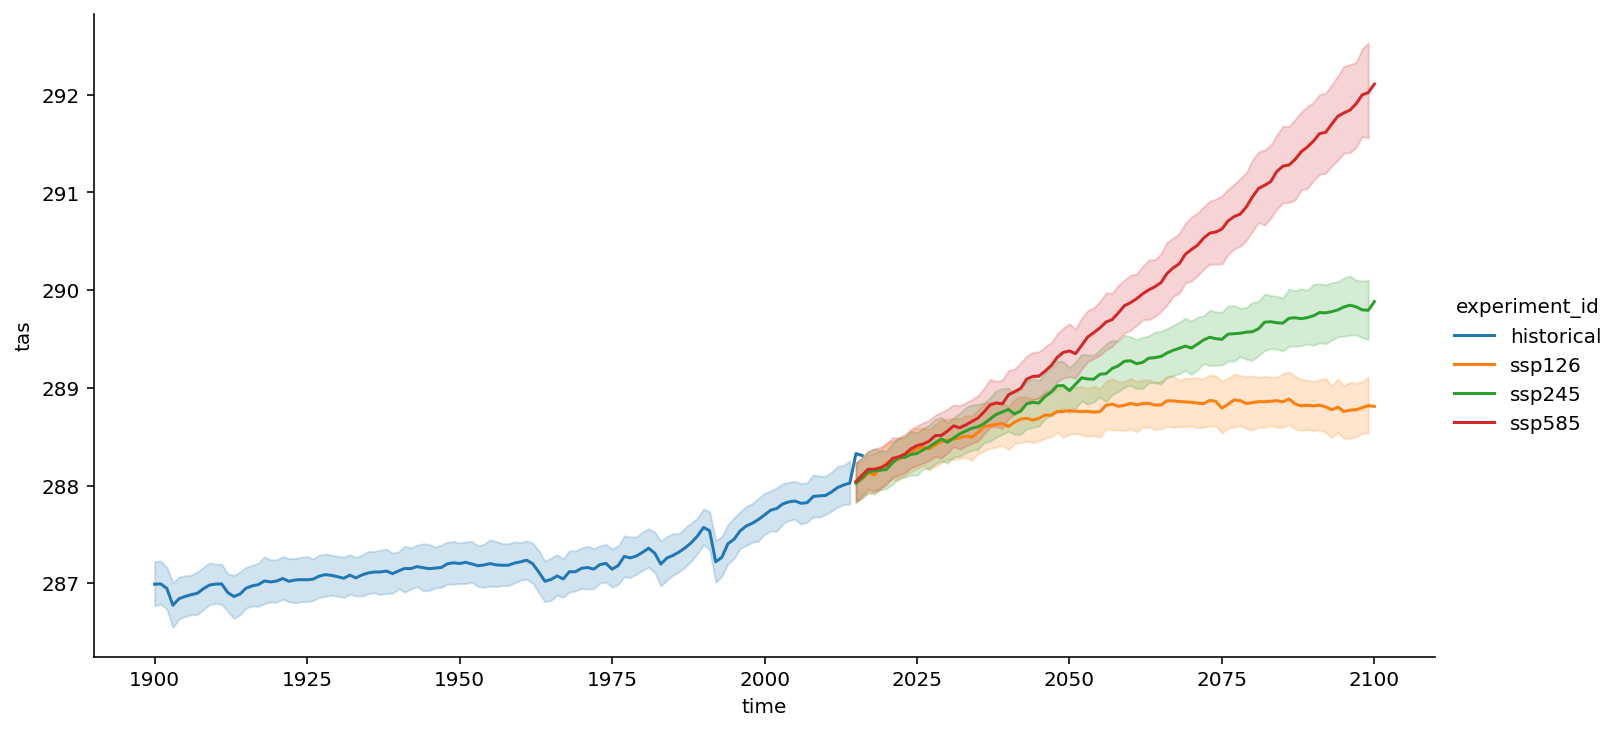

In [304]:
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.relplot(data=df_all, x="time",
            y="tas", hue="experiment_id",
            kind="line", ci=95, aspect=2);

Nice!